#Ερώτημα Α Παραδοτέο 1

In [ ]:
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer # για το paraphrasing
from nltk.tokenize import TreebankWordTokenizer
import spacy

nlp=spacy.load("en_core_web_sm")

tokenizerNLTK=TreebankWordTokenizer()


#Εργαλείο για αναδιατύπωση για την αναδιατύπωση
tokenizer=AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model=AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")

#Αρχικοποίηση προτάσεων
sentence_first="Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives."
sentence_second="Anyway, I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation."

def getTags(text):
    wordTag=nlp(text)
    return [(token.text,token.tag_) for token in wordTag]

def correct_grammar(text):
    #Διαχωρισμός του κειμένου σε tokens
    tokens=tokenizerNLTK.tokenize(text)
    
    #Βρισκούμε το μέρος του λόγου κάθε λέξης
    tag=getTags(text)
    
    correct=[]
    counter=0
    
    while counter<len(tag):
        #Πρόσβαση στην λέξη και τι μέρος του λόγου είναι
        word,t=tag[counter] 
        
        #Κανόνας Πρώτος αν δεν πρόταση ξεκινά με ουσιαστικό χωρίς άρθρο
        if t=="NN" and counter==0:
            correct.append("a")
            correct.append(word)
        #Εφαρμοφή δεύτερου κανόνα αν έχουμε ουσιαστικό που ακολουθεί άλλο ουσιαστικό χωρίς σύνδεση
        elif t=="NN" and tag[counter-1][1] not in ["DT","JJ"]:
            #Αν υπάρχει πριν ουσιαστικό, θέλουμε σύνδεση
            if tag[counter-1][1]=="NN":
                correct.append("of")
                correct.append(word)
            else:
                correct.append(word)
        #Εφαρμογή τρίτου κάνονα αν βρούμε at και έχουμε χρονική λέξη
        elif word.lower()=="at" and counter+1<len(tag):
            nextWord,nextTag=tag[counter+1]
            if nextWord.lower() in ["recent","next","past"]:
                correct.append("in")
            else:
                correct.append(word)
        else:
            #Δεν βρίσκεται κάποιος κανόνας
            correct.append(word)
        counter+=1
    return " ".join(correct)

def paraphrase(text):
    #Προσθέτουμε την οδηγία->αναδιατύπωση
    input=f"paraphrase:{text}</s>"
    
    #Δημιουργία tokens
    tokens=tokenizer.encode(input,return_tensors="pt")
    
    #Δημιουργία απάντησης
    paraphrase_text=model.generate(
        tokens,
        no_repeat_ngram_size=2,#Αποφευγεί να πεί την ίδια ακολουθία
        num_beams=5,
        early_stopping=True,
    )
    
    return tokenizer.decode(paraphrase_text[0],skip_special_tokens=True)

grammarCorrect1=paraphrase(sentence_first)
correct_sentence1=correct_grammar(grammarCorrect1)
print("Sentence first:",correct_sentence1)
    
grammarCorrect2=paraphrase(sentence_second)
correct_sentence2=correct_grammar(grammarCorrect2)
print("Sentence second:",correct_sentence2)

Sentence first: a Today is our dragon of boat of festival , in our Chinese culture , to celebrate it with all safe and great
Sentence second: Anyway , I believe the team , although a bit delayed and less communication in recent days ,


#Ερώτημα Β Παραδοτέο 1 

#Υλοποιήση Κειμένου 1

In [ ]:
from transformers import pipeline

#Φορτώνουμε τον pipline paraphraser bart
paraphraserBart=pipeline("text2text-generation",model="facebook/bart-large-cnn")

text="""Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""

paraphraseText=paraphraserBart(text,max_length=256,do_sample=True)#Παραγωγή ποικιλία
print("method Bart:",paraphraseText[0]['generated_text'])

Device set to use cpu


method Bart: Thank your message to show our words to the doctor, as his next contract checking, to all of us. Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. I am very appreciated the full support of the                professor, for our Springer proceedings publication.


In [ ]:
from transformers import pipeline

#Φόρτωση 
paraphraserT5=pipeline("text2text-generation",model="Vamsi/T5_Paraphrase_Paws")

text="""Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""

#Υπόδειξη task
inputText="paraphrase: "+text
out=paraphraserT5(inputText,max_length=256,do_sample=True)
print("method T5:",out[0]['generated_text'])

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


method T5: Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago.


In [17]:
from transformers import pipeline

#Φόρτωση 
paraphraserPegasus=pipeline("text2text-generation",model="google/pegasus-xsum")

text="""Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""

output=paraphraserPegasus(text,max_length=256,do_sample=True)
print("method Pegasus:",out[0]['generated_text'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


method Pegasus: Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago.


#Υλοποιήση Κειμένου 2

In [1]:
from transformers import pipeline

#Φορτώνουμε τον pipline paraphraser bart
paraphraserBart=pipeline("text2text-generation",model="facebook/bart-large-cnn")

text="""During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""

paraphraseText=paraphraserBart(text,max_length=256,do_sample=True)
print("method Bart:",paraphraseText[0]['generated_text'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device set to use cpu


method Bart: I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Please remind me please, if the doctor still plan for the acknowledgments section edit before sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so.


In [1]:
from transformers import pipeline

#Φόρτωση 
paraphraserT5=pipeline("text2text-generation",model="Vamsi/T5_Paraphrase_Paws")

text="""During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""


inputText="paraphrase: "+text
out=paraphraserT5(inputText,max_length=256,do_sample=True)
print("method T5:",out[0]['generated_text'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


method T5: When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it


In [2]:
from transformers import pipeline

#Φόρτωση 
paraphraserPegasus=pipeline("text2text-generation",model="google/pegasus-xsum")

text="""During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""

output=paraphraserPegasus(text,max_length=256,do_sample=True)
print("method Pegasus:",out[0]['generated_text'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


method Pegasus: When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it


#Ερώτημα C Παραδοτέο 1 

#Υλοποίηση κειμένου 1

In [ ]:
from bert_score import score
import pandas as pd

originalText=["""Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""]

bartText=["""Thank your message to show our words to the doctor, as his next contract checking, to all of us. Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. I am very appreciated the full support of the                professor, for our Springer proceedings publication."""]
t5Text=["""Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago."""]
pegasusText=["""Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago."""]

#Θα υπολογίσουμε τα score
P2,R2,F2=score(bartText,originalText,lang="en",verbose=True,model_type="bert-base-uncased")
P3,R3,F3=score(t5Text,originalText,lang="en",verbose=True,model_type="bert-base-uncased")
P4,R4,F4=score(pegasusText,originalText,lang="en",verbose=True,model_type="bert-base-uncased")

#Δημιουργία Πίνακα Αποτελεσμάτων
table=pd.DataFrame(
    {
        "Methods":["Bart","T5","Pegasus"],
        "BERTScore":[F2[0].item(),F3[0].item(),F4[0].item()]
    }
)
print(table)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


done in 3.85 seconds, 0.26 sentences/sec
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


done in 1.06 seconds, 0.94 sentences/sec
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 335.01it/s]

done in 1.10 seconds, 0.91 sentences/sec
   Methods  BERTScore
0     Bart   0.848044
1       T5   0.838575
2  Pegasus   0.838575


#Υλοποιήση κειμένου 2

In [ ]:
from bert_score import score
import pandas as pd

originalText=["""During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""]

bartText=["""I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Please remind me please, if the doctor still plan for the acknowledgments section edit before sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so."""]
t5Text=["""When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"""]
pegasusText=["""When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"""]

#Θα υπολογίσουμε τα score
P2,R2,F2=score(bartText,originalText,lang="en",verbose=True,model_type="bert-base-uncased")
P3,R3,F3=score(t5Text,originalText,lang="en",verbose=True,model_type="bert-base-uncased")
P4,R4,F4=score(pegasusText,originalText,lang="en",verbose=True,model_type="bert-base-uncased")

#Δημιουργία Πίνακα Αποτελεσμάτων
table=pd.DataFrame(
    {
        "Methods":["Bart","T5","Pegasus"],
        "BERTScore":[F2[0].item(),F3[0].item(),F4[0].item()]
    }
)
print(table)

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<?, ?it/s]


done in 0.84 seconds, 1.19 sentences/sec
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


done in 2.55 seconds, 0.39 sentences/sec
calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<?, ?it/s]

done in 1.47 seconds, 0.68 sentences/sec
   Methods  BERTScore
0     Bart   0.828705
1       T5   0.757840
2  Pegasus   0.757840


#Παραδοτέο 2:Υπολογιστική Ανάλυση

In [ ]:
#Θα υπολογίσουμε για το (1Α)-->προτάσεις

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import math

#Φόρτωση μόντέλου
model=SentenceTransformer('all-MiniLM-L6-v2')

#Περνάμε τις προτάσεις
text1="Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives."
paraphrase_text1=" a Today is our dragon of boat of festival , in our Chinese culture , to celebrate it with all safe and great"

text2="Anyway, I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation."
paraphrase_text2=" Anyway , I believe the team , although a bit delayed and less communication in recent days ,"

#Μετατροπή σε διανυσματικές αναπαραστάσεις
emb1=model.encode([text1,paraphrase_text1])
emb2=model.encode([text2,paraphrase_text2])


#Υπολογισμός βαθμολογίας συνημίτονου
similarity1=cosine_similarity([emb1[0],emb1[1]])[0][0]
similarity2=cosine_similarity([emb2[0],emb2[1]])[0][0]

#εμφάνιση μόνο πρώτου δεκαδικού ψηφιού
print(f"First sentence similarity:{math.floor(similarity1*10)/10}")
print(f"Second sentence similarity:{math.floor(similarity2*10)/10}")

From C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



First sentence similarity:0.9
Second sentence similarity:1.0


In [19]:
#Ομοιότητα για (1Β)--->κείμενα


#Περνάμε τα κείμενα (1)
originalText="""Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication"""

paraphraseTextBart="Thank your message to show our words to the doctor, as his next contract checking, to all of us. Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. I am very appreciated the full support of the                professor, for our Springer proceedings publication."
paraphraseTextT5="When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"
paraphraseTextPegasus="Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago."
#Μετατροπή για να κατανοήτη στον υπολογιστή
emb_bart=model.encode([originalText,paraphraseTextBart])
emb_T5=model.encode([originalText,paraphraseTextT5])
emb_pegasus=model.encode([originalText,paraphraseTextPegasus])


#Υπολογισμός βαθμολογίας συνημίτονου
similarityBART=cosine_similarity([emb_bart[0],emb_bart[1]])[0][0]
similarityT5=cosine_similarity([emb_T5[0],emb_T5[1]])[0][0]
similarityPegasus=cosine_similarity([emb_pegasus[0],emb_pegasus[1]])[0][0]

print(f"Text similarity method Bart:{math.floor(similarityBART*10)/10}")
print(f"Text similarity method T5:{math.floor(similarityT5*10)/10}")
print(f"Text similarity method Pegasus:{math.floor(similarityPegasus*10)/10}")



Text similarity method Bart:0.9
Text similarity method T5:0.9
Text similarity method Pegasus:0.9


#Οπτικοποίηση


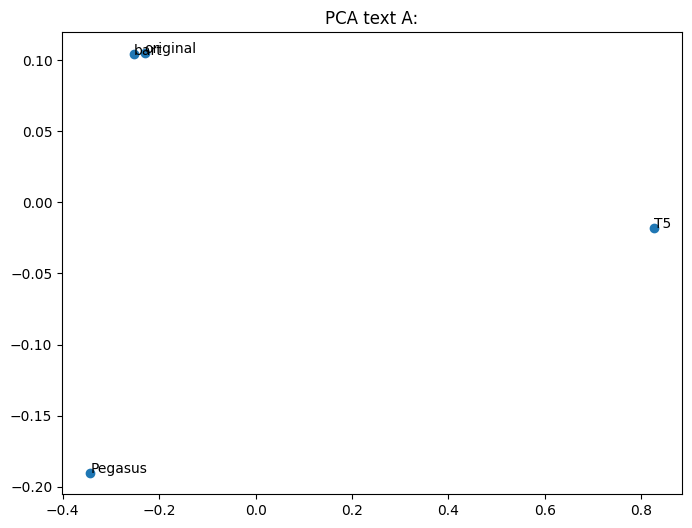

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt #για σχεδιασμό

model=SentenceTransformer('all-MiniLM-L6-v2')

#Δημιουργία λιστών 
listOftexts=[
    """Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in
our lives. Hope you too, to enjoy it as my deepest wishes.
Thank your message to show our words to the doctor, as his next contract checking, to all of us.
I got this message to see the approved message. In fact, I have received the message from the
professor, to show me, this, a couple of days ago. I am very appreciated the full support of the
professor, for our Springer proceedings publication""",
    "Thank your message to show our words to the doctor, as his next contract checking, to all of us. Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. I am very appreciated the full support of the                professor, for our Springer proceedings publication.",
    "When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it",
    "Today is our Dragon Boat Festival, in our Chinese cultures, to celebrate it with all the other safe and great in our lives; hope that will also be yours to enjoy it as my deepest wishes. Thank for your message to show our words to the doctor, as his next contract checking, to all of us; I also received the message from the professor to show me this, a couple of days ago."
]

#Δημιουργία διανυσματικών αναπαραστάσεων
vectorRepre=model.encode(listOftexts) #Κάθε vector έχει 384 διαστάσεις

#Μείωση διαστάσεων μέσω PCA
pca=PCA(n_components=2)
#Μετατροπή
reducedVector=pca.fit_transform(vectorRepre)

#Δημιουργία διαγράμματος πλαισού 8*6
plt.figure(figsize=(8,6))
#προσβάση στους άξονες-->διάγραμμα διασπόρας
plt.scatter(reducedVector[:,0],reducedVector[:,1])

types=["original","bart","T5","Pegasus"]
#Προσθήκη ετικετών
for i, text in enumerate(listOftexts):
    #Τοποθέτηση ονόματος στις συντεταγμένες
    plt.annotate(types[i],(reducedVector[i,0],reducedVector[i,1]))
    
plt.title("PCA text A:")
plt.show()

#Εφαρμογή ίδιας λειτουργίας για το κείμενο 2

In [12]:
#Ομοιότητα για (1Β)--->κείμενα
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import math

model=SentenceTransformer('all-MiniLM-L6-v2')

#Περνάμε τα κείμενα (2)
originalText="""During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets"""

paraphraseTextBart="I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Please remind me please, if the doctor still plan for the acknowledgments section edit before sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so."
paraphraseTextT5="When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"
paraphraseTextPegasus="When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"
#Μετατροπή για να κατανοήτη στον υπολογιστή
emb_bart=model.encode([originalText,paraphraseTextBart])
emb_T5=model.encode([originalText,paraphraseTextT5])
emb_pegasus=model.encode([originalText,paraphraseTextPegasus])


#Υπολογισμός βαθμολογίας συνημίτονου
similarityBART=cosine_similarity([emb_bart[0],emb_bart[1]])[0][0]
similarityT5=cosine_similarity([emb_T5[0],emb_T5[1]])[0][0]
similarityPegasus=cosine_similarity([emb_pegasus[0],emb_pegasus[1]])[0][0]

print(f"Text similarity method Bart:{math.floor(similarityBART*10)/10}")
print(f"Text similarity method T5:{math.floor(similarityT5*10)/10}")
print(f"Text similarity method Pegasus:{math.floor(similarityPegasus*10)/10}")

Text similarity method Bart:1.0
Text similarity method T5:1.0
Text similarity method Pegasus:1.0


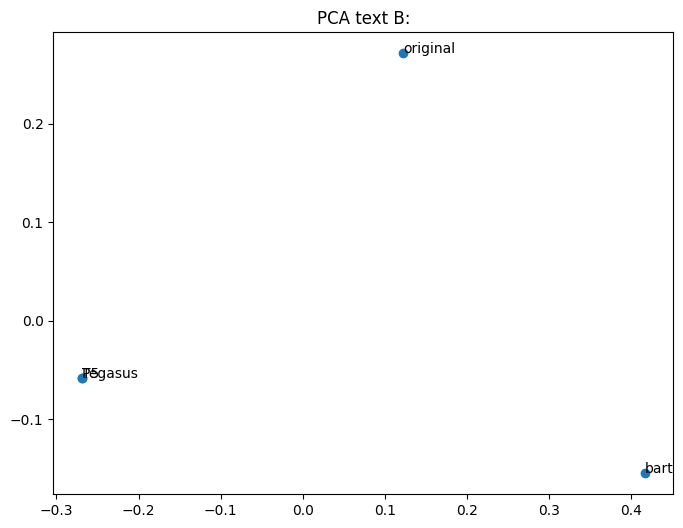

In [15]:
#Οπτικοποίση
#Δημιουργία λιστών 
listOftexts=[
    """During our final discuss, I told him about the new submission — the one we were waiting since
last autumn, but the updates was confusing as it not included the full feedback from reviewer or
maybe editor?
Anyway, I believe the team, although bit delay and less communication at recent days, they really
tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance
and efforts until the Springer link came finally last week, I think.
Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before
he sending again. Because I didn't see that part final yet, or maybe I missed, I apologize if so.
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future
targets""",
    "I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Please remind me please, if the doctor still plan for the acknowledgments section edit before sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so.",
    "When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it",
    "When we went to our final discussion, I sent him the new submission — the one we were waiting on since last autumn , but the updates were confusing , as it did not include all the full feedback from the reviewer or maybe the editor ? Anyway , I would like to thank the Team for the acceptance and efforts until Springer Link finally arrived last week , I can ask for feedback if the doctor still plan for the acknowledgement section before sending . Because I did not see that part final yet, or maybe I missed it"
]

#Δημιουργία διανυσματικών αναπαραστάσεων
vectorRepre=model.encode(listOftexts)

#Μείωση διαστάσεων μέσω PCA
pca=PCA(n_components=2)
reducedVector=pca.fit_transform(vectorRepre)

#Δημιουργία διαγράμματος
plt.figure(figsize=(8,6))
plt.scatter(reducedVector[:,0],reducedVector[:,1])

types=["original","bart","T5","Pegasus"]
#Προσθήκη ετικετών
for i, text in enumerate(listOftexts):
    #Τοποθέτηση ονόματος
    plt.annotate(types[i],(reducedVector[i,0],reducedVector[i,1]))
    
plt.title("PCA text B:")
plt.show()